In [1]:
import json
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_tukey
from statannotations.Annotator import Annotator 

he_name_disease_map = {
    "PS23-14642_A1_Ulcer_HE-CK.svs_aligned.ome": "ulcer",
    "PS23-18359_D2_Adenoma_HE-CK.svs_aligned.ome": "adenoma",
    "PS23-15535_A1_Non-Spec_HE-CD3.svs_aligned.ome": "non-spec",
    "PS23-18669_A1_N_HE-CD3.svs_aligned.ome": "normal",
    "PS23-15535_A1_Non-Spec_HE-CK.svs_aligned.ome": "non-spec",
    "PS23-18669_A1_N_HE-CK.svs_aligned.ome": "normal",
    "PS23-15709_A1_PS23-20460_A1_NET_HE-CK.svs_aligned.ome": "net",
    "PS23-19820_A_PS23-20019_A1_PS23-20493_A1_Adenoma_HE-CK.svs_aligned.ome": "adenoma",
    "PS23-16539_A_PS23-16539_B1_PS23-10072_A1_Eosc_HE-CK.svs_aligned.ome":"eosc",
    "PS23-20420_A1_PS23-20442_A1_N_HE-CD3.svs_aligned.ome": "normal",
    "PS23-17071_A1_HE-CD3.svs_aligned.ome": "coeliac",
    "PS23-20420_A1_PS23-20442_A1_N_HE-CK.svs_aligned.ome" : "normal",
    "PS23-17071_A1_HE-CK.svs_aligned.ome": "coeliac",
    "PS23-21268_A1_PS23-21268_B1_HE-CK.svs_aligned.ome": "coeliac",
    "PS23-17345_A1_PS23-17706_A1_N_HE-CD3.svs_aligned.ome": "normal",
    "PS23-21422_A1_PS23-21433_B1_PS23-22604_A1_HE-CK.svs_aligned.ome": "coeliac",
    "PS23-17345_A1_PS23-17706_A1_N_HE-CK.svs_aligned.ome": "normal",
    "PS23-21433_A1_PS23-21433_B1_PS23-22604_A1_HE-CD3.svs_aligned.ome": "coeliac",
    "PS23-17771_A1_PS23-17948_N_HE-CK.svs_aligned.ome": "normal",
    "PS23-22706_A1_PS23-22706_B1_PS23-24449_A1_HE-CD3.svs_aligned.ome": "coeliac",
    "PS23-18001_A1_N_HE-CD3.svs_aligned.ome": "normal",
    "PS23-22706_A1_PS23-22706_B1_PS23-24449_A1_HE-CK.svs_aligned.ome": "coeliac",
    "PS23-18001_A1_N_HE-CK.svs_aligned.ome": "normal",
    "PS23-24970_A1_PS23-09489_A1_Carcinoma_HE-CK.svs_aligned.ome": "carcinoma",
    "PS23-18316_A1_PS23-18379_A1_PS23-18656_A1_N_HE-CD3.svs_aligned.ome": "normal",
    "PS23-25204_A1_PS23-17242_A1_N_HE-CD3.svs_aligned.ome": "normal",
    "PS23-18316_A1_PS23-18379_A1_PS23-18656_A1_N_HE-CK.svs_aligned.ome": "normal",
    "PS23-25204_A1_PS23-17242_A1_N_HE-CK.svs_aligned.ome": "normal",
    "PS23-18359_A1_Adenoma_HE-CK.svs_aligned.ome": "adenoma",                         
    "PS23-25749_A1_PS23-28165_A1_HE-CD3.svs_aligned.ome": "coeliac",
    "PS23-18359_B1_Adenoma_HE-CK.svs_aligned.ome": "adenoma",
    "PS23-25749_A1_PS23-28165_A1_HE-CK.svs_aligned.ome": "coeliac",
    "PS23-18359_D1_Adenoma_HE-CK.svs_aligned.ome": "adenoma",
}

In [ ]:
os.chdir('/rds/user/mf774/hpc-work/part_II_project/in-house/create-training-data/scripts/')

INPUT_CSV = "/rds/user/mf774/hpc-work/part_II_project/in-house/create-training-data/analysis/summary.csv"
OUTPUT_CSV = "/rds/user/mf774/hpc-work/part_II_project/in-house/create-training-data/analysis/summary_density_diagnosis.csv"
HE_DIRECTORIES = '/rds/user/mf774/hpc-work/part_II_project/in-house/create-he-ihc-patches/he-ihc-patches/post-ihc/patches_256_256/'
stain_pattern = r"HE-(CD3|CK)"

def get_area_from_metadata(directory):
    metadata_path = f'{HE_DIRECTORIES}/{directory}/metadata.json'
    with open(metadata_path, "r") as f:
        metadata = json.load(f)
    area = metadata["tissue_area_og_mask"]
    return area

def get_stain_area_density_diagnosis(input_csv, output_csv):
    
    diagnoses = {"diagnosis": []}
    areas = {"area": []}
    stains = {"stain": []}

    # get area and diagnosis
    df = pd.read_csv(input_csv)
    wsis = list(df["wsi"])
    for wsi in wsis:
        diagnoses["diagnosis"].append(he_name_disease_map[wsi])
        areas["area"].append(get_area_from_metadata(wsi))
        stains["stain"].append(re.search(stain_pattern, wsi).group(1))
    diagnoses = pd.DataFrame(diagnoses)
    areas = pd.DataFrame(areas)
    stains = pd.DataFrame(stains)
    df['diagnosis'] = diagnoses
    df['area'] = areas
    df['cell_type'] = stains

    # calculate nuclei density 
    df['pos_nuc_density'] = (df['positive_nuclei'] / df['area']) * 1000 
    df['neg_nuc_density'] = (df['negative_nuclei'] / df['area']) * 1000
    df['total_nuc_density'] = (df["total_nuclei"] / df['area']) * 1000
    
    df.to_csv(output_csv, index=False)
    print(f"Processed data saved to {output_csv}")
    return

# calculate_nuclei_densities(INPUT_CSV, OUTPUT_CSV)
get_stain_area_density_diagnosis(INPUT_CSV, OUTPUT_CSV)

Processed data saved to summary_density_diagnosis.csv


/tmp/ipykernel_3876327/3178839799.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_3876327/3178839799.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_3876327/3178839799.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')


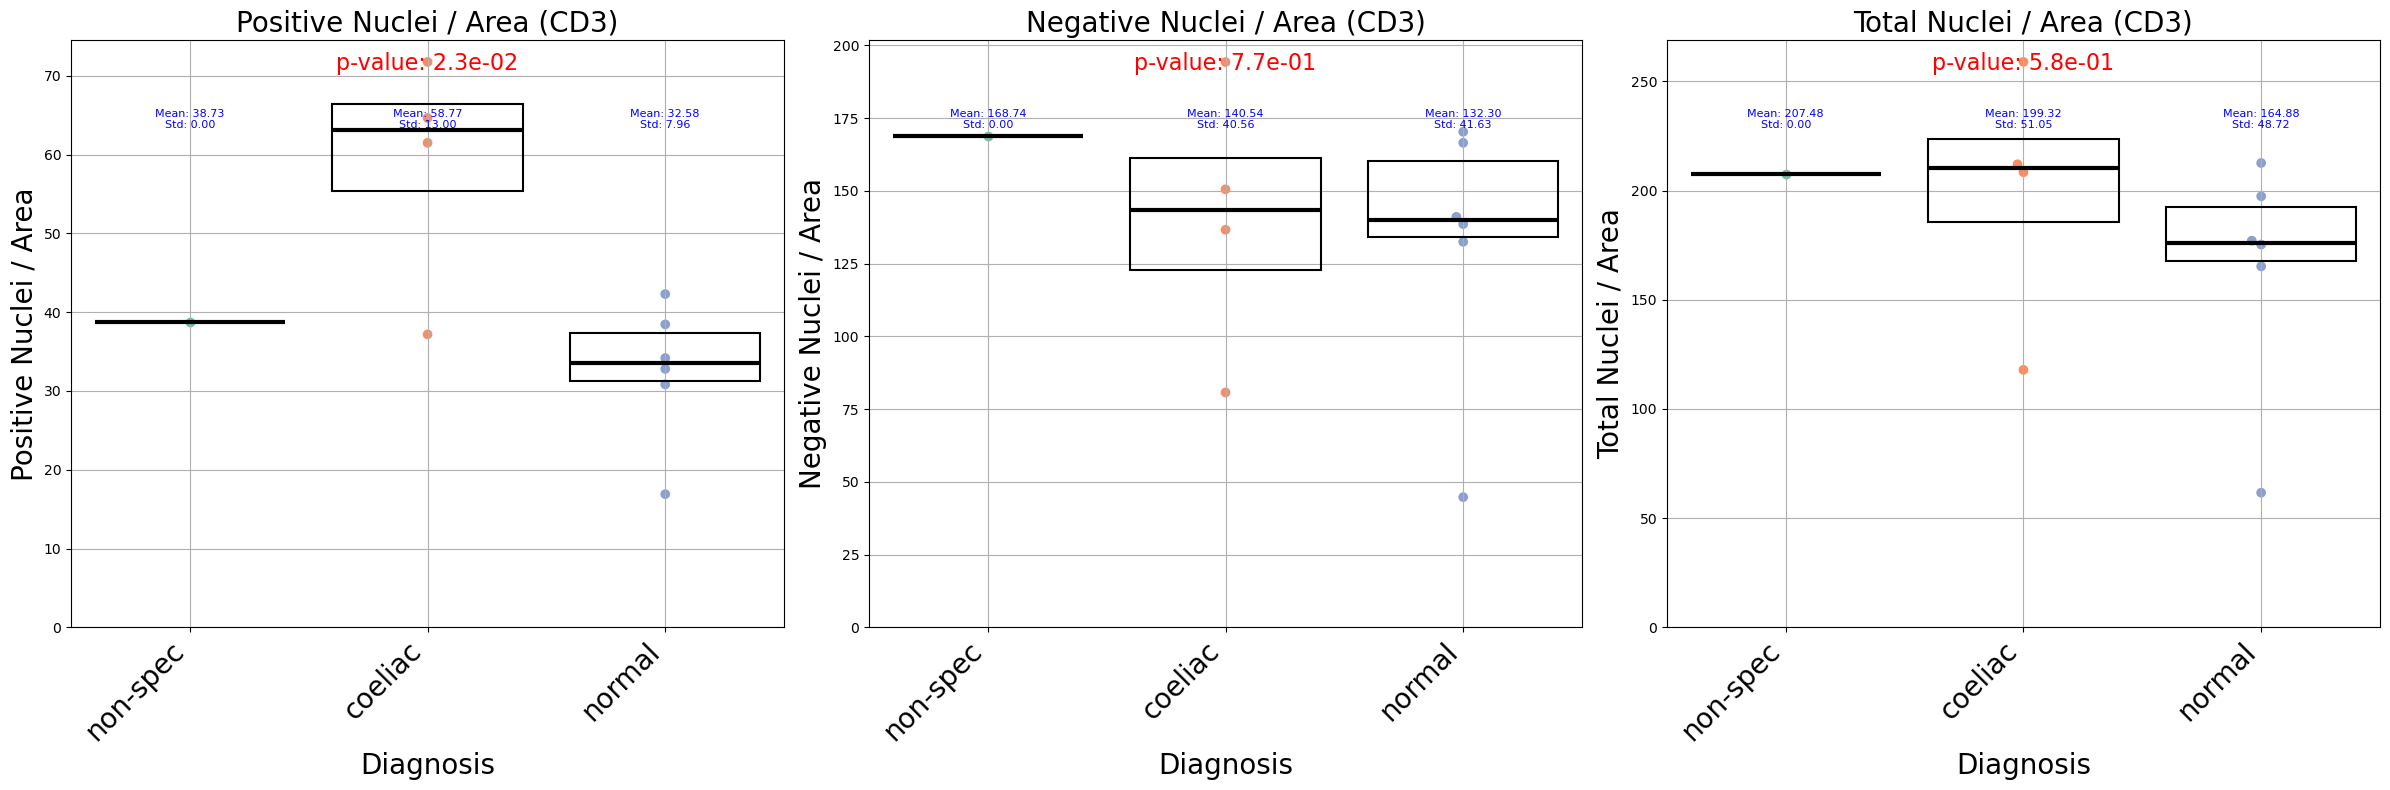

In [ ]:
# Load data
file_path = "/rds/user/mf774/hpc-work/part_II_project/in-house/create-training-data/analysis/summary_density_diagnosis.csv"
data = pd.read_csv(file_path)

# Filter data for CD3 and CK
cd3_data = data[data["cell_type"] == "CD3"]
ck_data = data[data["cell_type"] == "CK"]

# Define function to generate plots
def plot_data(subset_data, cell_type):
    metrics = ["pos_nuc_density", "neg_nuc_density", "total_nuc_density"]
    metric_names = ["Positive Nuclei / Area", "Negative Nuclei / Area", "Total Nuclei / Area"]
    
    groups = subset_data['diagnosis'].unique()

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for idx, metric in enumerate(metrics):
        sns.swarmplot(ax=axes[idx], x='diagnosis', y=metric, data=subset_data, hue='diagnosis', palette="Set2", size=7, alpha=1, zorder=1)
        sns.boxplot(ax=axes[idx], x='diagnosis', y=metric, data=subset_data, showmeans=False, meanline=False,
                    showfliers=False, whiskerprops={'visible': False}, capprops={'visible': False},
                    medianprops={'color': 'black', 'linewidth': 3, 'zorder': 2},
                    boxprops={'facecolor': 'none', 'edgecolor': 'black', 'linewidth': 1.5, 'zorder': 2})

        axes[idx].set_title(metric_names[idx] + f" ({cell_type})", fontsize=20)
        axes[idx].set_xlabel('Diagnosis', fontsize=20)
        axes[idx].set_ylabel(metric_names[idx], fontsize=20)
        axes[idx].grid(True)
        axes[idx].set_ylim(bottom=0)

        for label in axes[idx].get_xticklabels():
            label.set_fontsize(20)
            
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')

        # ANOVA test
        group_data = [subset_data[subset_data['diagnosis'] == group][metric] for group in groups]
        f_stat, p_value = f_oneway(*group_data)

        # tukey_hsd test
        """
        # code from https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
        tukey_df = posthoc_tukey(subset_data, val_col=metric, group_col="diagnosis")
        remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
        tukey_df[remove] = np.nan
        molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
        pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
        # print("pairs", pairs)
        p_values = [i[1]["value"] for i in molten_df.iterrows()]
        annotator = Annotator(
            axes[idx], pairs, data=subset_data, x="diagnosis", y=metric, zorder=1
        )
        annotator.configure(text_format="star", loc="inside")
        annotator.set_pvalues_and_annotate(p_values)
        """
    
        axes[idx].annotate(f'p-value: {p_value:.1e}', xy=(0.5, 0.95), xycoords='axes fraction',
                           ha='center', fontsize=16, color='red')
        
        # Calculate and display mean and std for each group
        for group in groups:
            group_data = subset_data[subset_data['diagnosis'] == group][metric]
            mean = np.mean(group_data)
            std = np.std(group_data)

            # Display mean and std on the plot (at the position of the group on the x-axis)
            x_pos = np.where(groups == group)[0][0]  # Find x position for the group
            axes[idx].text(x_pos, axes[idx].get_ylim()[1] * 0.85,  # Position above the plot
                        f'Mean: {mean:.2f}\nStd: {std:.2f}',
                        ha='center', fontsize=8, color='blue')

    plt.tight_layout()
    plt.savefig(f'/rds/user/mf774/hpc-work/part_II_project/in-house/create-training-data/analysis/scatterplot_{cell_type}.png')
    plt.show()

# Generate plots for CD3 and CK
# plot_data(cd3_data, "CD3")
plot_data(cd3_data, "CD3")